<a href="https://colab.research.google.com/github/AditiAgrawal95/CAECompressionSWinIRRestoration/blob/main/CAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import os 

In [13]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.autograd import Variable



In [14]:
def denorm(x,channels=None, w= None, h=None, resize=False):
  x= 0.5 * (x + 1)
  x=x.clamp(0,1) #https://www.geeksforgeeks.org/python-pytorch-clamp-method/#:~:text=clamp()%20method%20clamps%20all,and%20return%20a%20resulting%20tensor.&text=inp%3A%20This%20is%20input%20tensor,which%20input%20to%20be%20clamped.
  if resize:
    if channels is None or w is None or h is None:
      print('Number of channels,width,and height nust be provided for resize.')
    x=x.view(x.size(0),channels,w,h)
  return x


In [15]:
def show(img):
  if torch.cuda.is_available():
    img = img.cpu()
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))


In [16]:
## Device Selection
GPU = True
device_idx = 0
if GPU:
  device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
  device = torch.device("cpu")
print(device)

cpu


In [17]:
#Reproducibility
#We set a random seed to endure that your results are reproducible
if torch.cuda.is_available():
  torch.backends.cudann.deterministic = True
torch.manual_seed(0)

In [18]:
'''def rgb_to_ycbcr(image: torch.Tensor) -> torch.Tensor:
    r"""Convert an RGB image to YCbCr.

    .. image:: _static/img/rgb_to_ycbcr.png

    Args:
        image: RGB Image to be converted to YCbCr with shape :math:`(*, 3, H, W)`.

    Returns:
        YCbCr version of the image with shape :math:`(*, 3, H, W)`.

    Examples:
        >>> input = torch.rand(2, 3, 4, 5)
        >>> output = rgb_to_ycbcr(input)  # 2x3x4x5
    """
    if not isinstance(image, torch.Tensor):
        raise TypeError(f"Input type is not a torch.Tensor. Got {type(image)}")

    if len(image.shape) < 3 or image.shape[-3] != 3:
        raise ValueError(f"Input size must have a shape of (*, 3, H, W). Got {image.shape}")

    r: torch.Tensor = image[..., 0, :, :]
    g: torch.Tensor = image[..., 1, :, :]
    b: torch.Tensor = image[..., 2, :, :]

    delta: float = 0.5
    y: torch.Tensor = 0.299 * r + 0.587 * g + 0.114 * b
    cb: torch.Tensor = (b - y) * 0.564 + delta
    cr: torch.Tensor = (r - y) * 0.713 + delta
    return torch.stack([y, cb, cr], -3)'''

'def rgb_to_ycbcr(image: torch.Tensor) -> torch.Tensor:\n    r"""Convert an RGB image to YCbCr.\n\n    .. image:: _static/img/rgb_to_ycbcr.png\n\n    Args:\n        image: RGB Image to be converted to YCbCr with shape :math:`(*, 3, H, W)`.\n\n    Returns:\n        YCbCr version of the image with shape :math:`(*, 3, H, W)`.\n\n    Examples:\n        >>> input = torch.rand(2, 3, 4, 5)\n        >>> output = rgb_to_ycbcr(input)  # 2x3x4x5\n    """\n    if not isinstance(image, torch.Tensor):\n        raise TypeError(f"Input type is not a torch.Tensor. Got {type(image)}")\n\n    if len(image.shape) < 3 or image.shape[-3] != 3:\n        raise ValueError(f"Input size must have a shape of (*, 3, H, W). Got {image.shape}")\n\n    r: torch.Tensor = image[..., 0, :, :]\n    g: torch.Tensor = image[..., 1, :, :]\n    b: torch.Tensor = image[..., 2, :, :]\n\n    delta: float = 0.5\n    y: torch.Tensor = 0.299 * r + 0.587 * g + 0.114 * b\n    cb: torch.Tensor = (b - y) * 0.564 + delta\n    cr: torch

In [19]:
'''def ycbcr_to_rgb(image: torch.Tensor) -> torch.Tensor:
    r"""Convert an YCbCr image to RGB.

    The image data is assumed to be in the range of (0, 1).

    Args:
        image: YCbCr Image to be converted to RGB with shape :math:`(*, 3, H, W)`.

    Returns:
        RGB version of the image with shape :math:`(*, 3, H, W)`.

    Examples:
        >>> input = torch.rand(2, 3, 4, 5)
        >>> output = ycbcr_to_rgb(input)  # 2x3x4x5
    """
    if not isinstance(image, torch.Tensor):
        raise TypeError(f"Input type is not a torch.Tensor. Got {type(image)}")

    if len(image.shape) < 3 or image.shape[-3] != 3:
        raise ValueError(f"Input size must have a shape of (*, 3, H, W). Got {image.shape}")

    y: torch.Tensor = image[..., 0, :, :]
    cb: torch.Tensor = image[..., 1, :, :]
    cr: torch.Tensor = image[..., 2, :, :]

    delta: float = 0.5
    cb_shifted: torch.Tensor = cb - delta
    cr_shifted: torch.Tensor = cr - delta

    r: torch.Tensor = y + 1.403 * cr_shifted
    g: torch.Tensor = y - 0.714 * cr_shifted - 0.344 * cb_shifted
    b: torch.Tensor = y + 1.773 * cb_shifted
    return torch.stack([r, g, b], -3)'''

'def ycbcr_to_rgb(image: torch.Tensor) -> torch.Tensor:\n    r"""Convert an YCbCr image to RGB.\n\n    The image data is assumed to be in the range of (0, 1).\n\n    Args:\n        image: YCbCr Image to be converted to RGB with shape :math:`(*, 3, H, W)`.\n\n    Returns:\n        RGB version of the image with shape :math:`(*, 3, H, W)`.\n\n    Examples:\n        >>> input = torch.rand(2, 3, 4, 5)\n        >>> output = ycbcr_to_rgb(input)  # 2x3x4x5\n    """\n    if not isinstance(image, torch.Tensor):\n        raise TypeError(f"Input type is not a torch.Tensor. Got {type(image)}")\n\n    if len(image.shape) < 3 or image.shape[-3] != 3:\n        raise ValueError(f"Input size must have a shape of (*, 3, H, W). Got {image.shape}")\n\n    y: torch.Tensor = image[..., 0, :, :]\n    cb: torch.Tensor = image[..., 1, :, :]\n    cr: torch.Tensor = image[..., 2, :, :]\n\n    delta: float = 0.5\n    cb_shifted: torch.Tensor = cb - delta\n    cr_shifted: torch.Tensor = cr - delta\n\n    r: torch.T

In [22]:
#Data Loading
batch_size=128

if not os.path.exists('./CW/CAE'):
  os.makedirs('./CW/CAE')

NUM_TRAIN=49000
##ToTensor : Converts a PIL Image or numpy.ndarray (H x W x C) in the range
##           [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=(0.5,0.5,0.5), std= (0.5,0.5,0.5))])

transform_test= transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=(0.5,0.5,0.5), std= (0.5,0.5,0.5)),])

transform_train = transforms.Compose([transforms.RandomCrop(32, padding =4),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5)),])

data_dir='./datasets'
cifar10_train=datasets.CIFAR10(data_dir,train =True,download=True,transform = transform_train)
cifar10_val=datasets.CIFAR10(data_dir,train =True,download=True,transform = transform_test)
cifar10_test= datasets.CIFAR10(data_dir, train = False,download = True, transform = transform_test)
print("Shape of CIFAR 10 is: ",type(cifar10_train))
print('Image size: ' + str(len(cifar10_train)))

loader_train=DataLoader(cifar10_train,batch_size=batch_size,sampler= sampler.SubsetRandomSampler(range(NUM_TRAIN)))
loader_val= DataLoader(cifar10_val, batch_size=batch_size,sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN,5000)))
loader_test = DataLoader(cifar10_test,batch_size=batch_size)

print("Shape of loader_train is: ",type(loader_train))
print('Image size: ' + str(len(loader_train)))


it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:32, :, :, :]
save_image = (denorm(fixed_input), './CW/CAE/input_sample.png')

print("Type of fixed output is: ",type(fixed_input))
print("Size of fixed_input is: ",fixed_input.size())



  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./datasets/cifar-10-python.tar.gz to ./datasets
Files already downloaded and verified
Files already downloaded and verified
Shape of CIFAR 10 is:  <class 'torchvision.datasets.cifar.CIFAR10'>
Image size: 50000
Shape of loader_train is:  <class 'torch.utils.data.dataloader.DataLoader'>
Image size: 383
Type of fixed output is:  <class 'torch.Tensor'>
Size of fixed_input is:  torch.Size([32, 3, 32, 32])


In [23]:
## Convolution Autoencoder
##Hyper Parameter Selection
num_epochs = 5
learning_rate= 0.0001


In [26]:
## Define Model
## Choose a value for latent space dimension and use it in your model
hidden_size =256 # 16*4*4

def make_conv_bn_relu(in_channels,out_channels,kernel_size=3,stride=1,padding=1):
  return [
          nn.Conv2d(in_channels,out_channels,kernel_size=kernel_size,stride=stride,padding=padding,bias=False),
          nn.BatchNorm2d(out_channels),
          nn.PReLU()]
def make_transconv_bn_relu(in_channels,out_channels,kernel_size=3,stride=2,padding=0):
  return [
          nn.ConvTranspose2d(in_channels,out_channels,kernel_size=kernel_size,stride=stride,padding=padding,bias=False),
          nn.BatchNorm2d(out_channels),
          nn.PReLU()]
def make_transconv_tanh_final(in_channels, out_channels, kernel_size=3, stride=2, padding=0):
    return [
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size,  stride=stride, padding=padding, bias=False),
        nn.Tanh()]

class CAE(nn.Module):
  def __init__(self):
    super(CAE,self).__init__()

    ## Downsampling part
    self.down1 = nn.Sequential(*make_conv_bn_relu(3,64,kernel_size=3,stride =2 ,padding = 1))
    self.down2 = nn.Sequential(*make_conv_bn_relu(64,32,kernel_size=3,stride=2, padding = 1))
    self.down3 = nn.Sequential(*make_conv_bn_relu(32,16,kernel_size=3,stride = 2, padding=1)) 


    self.up1=nn.Sequential(*make_transconv_bn_relu(16,32,kernel_size=2,stride=2))  ##1
    self.up2=nn.Sequential(*make_transconv_bn_relu(32,64,kernel_size=2,stride=2))  ##2
    self.up3=nn.Sequential(*make_transconv_tanh_final(64,3,kernel_size=2,stride=2))  ## 3


  def encode(self,x):

    x = self.down1(x)
    x = self.down2(x)
    x = self.down3(x)


    ## Here the image is encoded/compressed
    return x

  def decode(self,z):

    z = self.up1(z)
    z = self.up2(z)
    z = self.up3(z)

    return z

  def forward(self,x):

    z= self.encode(x)
    recon = self.decode(z)
    return recon




In [27]:
## Define Loss Function 
criterion = nn.MSELoss()

def loss_function_CAE(recon_x,x):
  recon_loss=criterion(recon_x,x)
  return recon_loss




In [28]:
## Initialize Model and print number of parameters
model = CAE().to(device)
params = sum(p.numel() for  p in model.parameters() if p.requires_grad)
print("total number of parameters is: {}".format(params))
print(model)

total number of parameters is: 36197
CAE(
  (down1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
  )
  (down2): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
  )
  (down3): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
  )
  (up1): Sequential(
    (0): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
  )
  (up2): Sequential(
   

In [29]:
## Choose aand Initialize Optimizer
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

In [30]:
#Train
train_losses = []
model.train()
for epoch in range(num_epochs):
  train_loss = 0
  print('Size of loader_train is : ' + str(len(loader_train)))
  for batch_idx, data in enumerate(loader_train):
    img, _ = data
    #print("Type of img is: ",type(img))
    #img = rgb_to_ycbcr(img1)
    #print("Type of img after converting to yCrCB is: ",type(img))

    img = img.to(device)
    optimizer.zero_grad()
    # forward
    recon_batch = model(img)
    ## denorm the image 
    #recon_batch2=denorm(recon_batch)
    #recon_batch3=ycbcr_to_rgb(recon_batch2)

    loss = loss_function_CAE(recon_batch, img)

    # backward
    loss.backward()
    train_loss += loss.item()
    optimizer.step()

  print('epoch [{}/{}],loss :{:.4f}'.format(epoch + 1,num_epochs, train_loss/ len(loader_train)))
  recona = model(fixed_input.to(device))
  recona = denorm(recona.cpu())
  ##save_image(recona, './CW/CAE/reconstructed_epoch.png')#.format(epoch))
  train_losses.append(train_loss/ len(loader_train))

# Save the model and loss values
np.save('./CW/CAE/train_losses.npy', np.array(train_losses))
torch.save(model.state_dict(), './CW/CAE/CAE_model2.pth')

Size of loader_train is : 383
epoch [1/5],loss :0.1971
Size of loader_train is : 383
epoch [2/5],loss :0.0617
Size of loader_train is : 383
epoch [3/5],loss :0.0428
Size of loader_train is : 383
epoch [4/5],loss :0.0361
Size of loader_train is : 383
epoch [5/5],loss :0.0320


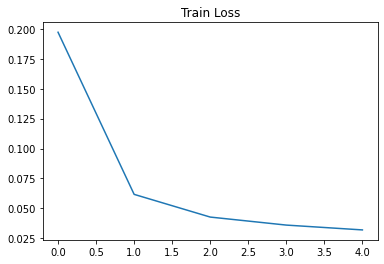

In [31]:
 ##Train LOss curve
train_losses = np.load('./CW/CAE/train_losses.npy')
plt.plot(list(range(0,train_losses.shape[0])), train_losses)
plt.title('Train Loss')
plt.show()

In [32]:
## Test set reconstruction error
# load the model
model.load_state_dict(torch.load('./CW/CAE/CAE_model2.pth'))
model.eval()
test_loss = 0
with torch.no_grad():
    for i, data in enumerate(loader_test):
        img,_ = data
        #img = rgb_to_ycbcr(img1)
        img = img.to(device)
        recon_batch = model(img)
        ## denorm the image 
        #recon_batch2=denorm(recon_batch)
        #recon_batch3=ycbcr_to_rgb(recon_batch2)
        #recon_batch = model(img)
        test_loss += loss_function_CAE(recon_batch, img)
    # loss calculated over the whole test set
    test_loss /= len(loader_test.dataset)
    print('Test set loss: {:.5f}'.format(test_loss))

Test set loss: 0.00021


/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:64: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  "The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. "


The sizze of img is:  torch.Size([3, 138, 274])


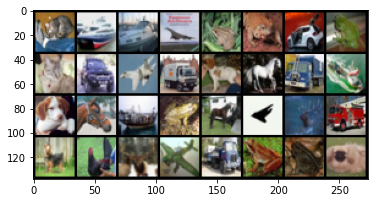

In [84]:
## Test set images and reconstructions
# load the model
import torchvision
import torchvision.transforms as T
from PIL import Image
model.load_state_dict(torch.load('./CW/CAE/CAE_model2.pth'))
it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:32, :, :, :]

# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)

show(img)
print("The sizze of img is: ", img.shape)

In [88]:
from torchvision.utils import save_image
save_image(img,'img6.png')

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:64: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  "The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. "


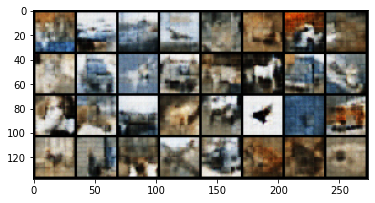

In [87]:
with torch.no_grad():
    # visualize the reconstructed images of the last batch of test set
    recon_batch = model.forward(fixed_input.to(device)).cpu()
    recon_batch = make_grid(denorm(recon_batch), nrow=8, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    show(recon_batch)

In [83]:

save_image(recon_batch,'recon6.png')

In [ ]:
import math
def calculate_psnr(img1, img2):
  img1 = img1.numpy().astype(np.float64)
  img2 = img2.numpy().astype(np.float64)
  mse = np.mean((img1 - img2)**2)
  if mse == 0:
    return float('inf')
  return 20 * math.log10(255.0 / math.sqrt(mse))

In [ ]:
type(recon_batch)

torch.Tensor

In [ ]:
recon_batch.shape[1]

32

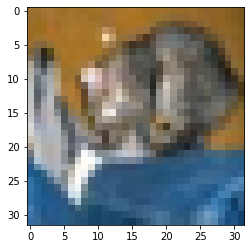

In [ ]:
show(img)

In [ ]:
result5=calculate_psnr(img,recon_batch)

In [ ]:
##print(result5)   --- 70.9987425569537

70.9987425569537


In [ ]:
##print(result4)  ---- 69.24729347565386

69.24729347565386


In [ ]:
##print(result2)  ---- 72.0766678288864

72.0766678288864


In [ ]:
##print(result3) ---- 71.06848423751096

71.06848423751096


In [ ]:
##print(result) ---- 68.80298894094759

68.80298894094759


In [41]:
from skimage.metrics import structural_similarity as ssim
import cv2

In [42]:
# Import images
image1 = cv2.imread('img1.png')
image2 = cv2.imread('recon1.png')

In [43]:
# Convert the images to grayscale
gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

In [44]:
s = ssim(gray1, gray2 )

In [ ]:
## print(s)  --- 0.7678400774761748  ##img 5

0.7678400774761748


In [ ]:
## print(s) --- 0.7678400774761748 ## img 4

0.6912463978940243


In [ ]:
## print(s) --- 0.8068936954138121  ## img3

0.8068936954138121


In [ ]:
## print(s) --- 0.8404630172197501 ##img2

0.8404630172197501


In [45]:
##print(s) ## --- 0.7324647203460863 ##img1 

0.7324647203460863
